# Compare logistic regression models of several mutations for a) covariates only and b) covariates with gene expression data to determine marginal gain using gene expression data 

In [4]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad
from IPython.display import display
import gc

In [5]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load Data

In [6]:
%%time
path = os.path.join('..', '..', 'download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

CPU times: user 102 ms, sys: 12.1 ms, total: 114 ms
Wall time: 114 ms


In [7]:
%%time
path = os.path.join('..', '..', 'download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 3min 22s, sys: 5.94 s, total: 3min 28s
Wall time: 3min 32s


In [40]:
%%time
path = os.path.join('..','..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 53s, sys: 5.24 s, total: 1min 58s
Wall time: 2min


In [41]:
X = {}
X['a'] = covariates
X['b'] = pd.concat([covariates,expression], axis=1)
for k in ['a','b']:
    print(X[k].shape)

(7306, 70)
(7306, 20600)


In [42]:
mutations = {
    '7157': 'TP53',   # tumor protein p53
    '7428': 'VHL',    # von Hippel-Lindau tumor suppressor
    '29126': 'CD274', # CD274 molecule
    '672': 'BRCA1',   # BRCA1, DNA repair associated
    '675': 'BRCA2',   # BRCA2, DNA repair associated
    '238': 'ALK',     # anaplastic lymphoma receptor tyrosine kinase
    '4221': 'MEN1',   # menin 1
    '5979': 'RET',    # ret proto-oncogene
}

## Median absolute deviation feature selection

In [43]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

## Define pipeline and Cross validation model fitting

In [44]:
# Parameter Sweep for Hyperparameters
param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [10 ** x for x in range(-3, 1)],
    'classify__l1_ratio': [0],
}

pipeline = Pipeline(steps=[
    ('imputer', Imputer()),    
    ('select', SelectKBest(fs_mad)),
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

cv_pipeline = {}
for k in ['a','b']:
    pg = param_grid.copy()
    if k == 'a': pg['select__k'] = ['all']
    elif k=='b': pg['select__k'] = [2000]
    cv_pipeline[k] =  GridSearchCV(estimator=pipeline, param_grid=pg, scoring='roc_auc')

In [45]:
def get_aurocs(X, y, pipeline, series):
    """
    Fit the classifier for the given mutation (y) and output predictions for it
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    pipeline.fit(X=X_train, y=y_train)
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)
    cv_score_df = grid_scores_to_df(pipeline.grid_scores_)
    series['mean_cv_auroc'] = cv_score_df.score.max()
    series['training_auroc'] = roc_auc_score(y_train, y_pred_train)
    series['testing_auroc'] = roc_auc_score(y_test, y_pred_test)
    return series

def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

auroc_dfs = {}

In [46]:
%%time
# Train model a: covariates only.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['a'], Y[m], cv_pipeline['a'], series))
auroc_dfs['a'] = pd.DataFrame(rows)
auroc_dfs['a'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)

CPU times: user 15.4 s, sys: 708 ms, total: 16.1 s
Wall time: 8.43 s


In [47]:
%%time
# Train model b: covariates with gene expression data.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['b'], Y[m], cv_pipeline['b'], series))
auroc_dfs['b'] = pd.DataFrame(rows)
auroc_dfs['b'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)

CPU times: user 19min 34s, sys: 15min 50s, total: 35min 25s
Wall time: 37min 53s


In [50]:
display(auroc_dfs['a'])
display(auroc_dfs['b'])

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc
2,238,ALK,0.841804,0.848602,0.762004
5,672,BRCA1,0.796844,0.847730,0.848682
7,675,BRCA2,0.775463,0.807858,0.883579
1,29126,CD274,0.840078,0.946829,0.848485
6,4221,MEN1,0.820176,0.835378,0.750197
0,5979,RET,0.814067,0.812435,0.857296
3,7157,TP53,0.847531,0.846363,0.855607
4,7428,VHL,0.974001,0.983446,0.993881


,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc
2,238,ALK,0.758945,0.924258,0.749452
5,672,BRCA1,0.730720,0.937022,0.704577
7,675,BRCA2,0.703267,0.875129,0.790180
1,29126,CD274,0.814358,0.999369,0.814325
6,4221,MEN1,0.672373,0.975399,0.672652
0,5979,RET,0.791483,0.938168,0.780480
3,7157,TP53,0.925459,0.931855,0.915583
4,7428,VHL,0.981365,0.996112,0.990297


In [65]:
auroc_dfs['a'].to_csv('auroc_covariates_only.tsv', index=False, sep='\t', float_format='%.5g')
auroc_dfs['b'].to_csv('auroc_covariates_and_expression.tsv', index=False, sep='\t', float_format='%.5g')
auroc_dfs['diff_ba'] = auroc_dfs['b'].loc[:,'mean_cv_auroc':]-auroc_dfs['a'].loc[:,'mean_cv_auroc':]
auroc_dfs['diff_ba'][['mutation', 'symbol']] = auroc_dfs['b'].loc[:, ['mutation', 'symbol']]
auroc_dfs['diff_ba']

,mean_cv_auroc,training_auroc,testing_auroc,mutation,symbol
2,-0.082859,0.075656,-0.012552,238,ALK
5,-0.066124,0.089293,-0.144105,672,BRCA1
7,-0.072196,0.067271,-0.093399,675,BRCA2
1,-0.025720,0.052540,-0.034160,29126,CD274
6,-0.147803,0.140021,-0.077545,4221,MEN1
0,-0.022584,0.125733,-0.076816,5979,RET
3,0.077928,0.085492,0.059976,7157,TP53
4,0.007364,0.012666,-0.003584,7428,VHL


# Covariates only vs covariates+expression model

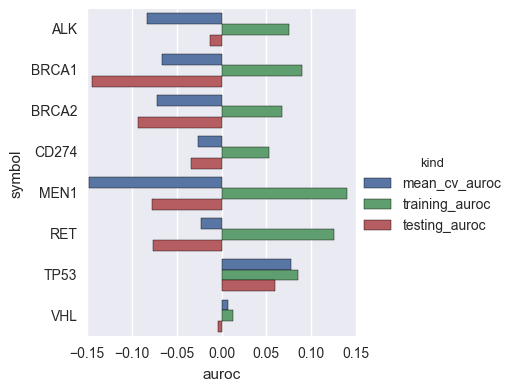

In [68]:
plot_df = pd.melt(auroc_dfs['diff_ba'], id_vars='symbol', value_vars=['mean_cv_auroc', 'training_auroc', 'testing_auroc'], var_name='kind', value_name='auroc')
grid = sns.factorplot(y='symbol', x='delta auroc', hue='kind', data=plot_df, kind="bar")
#xlimits = grid.ax.set_xlim(0.5, 1)